<strong><font size=5>Задание</font></strong><br/>

<b><font size=5>Содержание</font></b><a name="to_content."></a>
* [0. Описание](#0.)
* [1. Предобработка](#1.)
* [2. Анализ](#2.)
     - [2.1. Количество кликов и пользователей в разбивке по дням](#2.1.)
     - [2.2. Гипотеза № 1 (о количестве пользователей в день)](#2.2.)
     - [2.3. Количество событий на пользователя по дням](#2.3.)
     - [2.4. Количество пользователей по категориям](#2.4.)
     - [2.5. Количество пользователей и событий по типу действия](#2.5.)
     - [2.6. Гипотеза №2 (о конверсии)](#2.6.)
     - [2.7. Как часто добавляют](#2.7.)
     - [2.8. Гипотеза № 3 (о среднем количестве добавляемых объявлений в день)](#2.8.)
     - [2.9. Какие блоки добавляют](#2.9.)
     - [2.10. Действия внутри блоков (клики)](#2.10.)
* [3. Итоги](#3.)
* [4. Каких данных не хватает/что стоит сделать](#4.)



<strong><font size=3>Легенда</font></strong><a name="0."></a><br/>
[<font size="2">(к содержанию)</font>](#to_content.)

В личном кабинете [mos.ru](http://mos.ru) есть раздел "Избранное", который пользователи могут наполнять по своему усмотрению. Мы хотим сделать его более полезным для наших пользователей, но пока не проводили комплексный анализ.

В тестовом мы просим тебя посмотреть на текущую реализацию "Избранного", указать, какие решения кажутся тебе удачными, а какие - наоборот. Продумать 1-3 ключевых метрик  и предложить пару рекомендаций по улучшению (гипотезы и как будешь проверять). В помощь мы даем выгрузку из базы данных. Также просим тебя оценить выгрузку - достаточно ли данных для исследования? Если нет, то что хотелось бы добавить.

Выгрузка представляет собой агрегированную таблицу с 5 полями:

- <b>date</b> - дата события
- <b>hit_category</b> - событие (просмотр блока, добавление/удаление из избранного итд)
- <b>details</b> - содержимое блока в виде "Блок 1: %название%, Блок 2: %название%, Блок 3: %название%"
- <b>users</b> - кол-во пользователей
- <b>hits</b> - количество событий

<hr style="border: 1px solid #000;"> 

<strong><font size=5>1. Предобработка</font></strong><a name="1."></a><br/>
[<font size="2">(к содержанию)</font>](#to_content.)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from scipy.stats import ttest_ind
import statsmodels.stats.api as sms
sns.set(rc={'figure.figsize':(14, 8)})
pd.set_option('display.max_colwidth', -1)

In [2]:
fav = pd.read_csv('test_data.csv')
fav = fav.drop(['Unnamed: 0'], axis=1)

In [3]:
fav.head()

,date,hit_category,details,users,hits
0,2020-12-23,Просмотр блоков,"Блок 1: Проверка и пополнение баланса домашнего телефона МГТС, Блок 2: Запрос, изменение и отмена доступа к электронной медицинской карте",5.0,10.0
1,2020-12-13,Просмотр блоков,"Блок 1: Пополнение счёта карты ребёнка, Блок 2: Доступ к электронному дневнику, Блок 3: Запись в кружки, спортивные секции, дома творчества, Блок 4: Запись на приём к врачу, отмена и перенос записи",25.0,91.0
2,2020-12-29,Просмотр блоков,"Блок 1: Подача заявления и документов для назначения и предоставления единовременной компенсационной выплаты на возмещение расходов в связи с рождением (усыновлением) ребенка, Блок 2: Прием заявлений на запись (перевод) в образовательную организацию (дошкольные группы)",122.0,482.0
3,2021-01-11,Просмотр блоков,"Блок 1: Запись на приём к врачу, отмена и перенос записи, Блок 2: Предоставление сведений Фондом капитального ремонта многоквартирных домов города Москвы, Блок 3: Предоставление информации технического учета в городе Москве, Блок 4: Предоставление информации жилищного учёта, Блок 5: Подписка на информирование о результатах лабораторных, инструментальных и иных видов диагностических исследований",5.0,10.0
4,2020-12-05,Просмотр блоков,"Блок 1: Поиск медучреждений, Блок 2: Путёвки на отдых и оздоровление детей, Блок 3: Запись в кружки, спортивные секции, дома творчества, Блок 4: Запись на приём, Блок 5: Запись на приём к врачу, отмена и перенос записи",5.0,56.0


<strong><font size=3>Общая информация:</font></strong><br/>

In [4]:
fav.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129134 entries, 0 to 129133
Data columns (total 5 columns):
date            129134 non-null object
hit_category    129134 non-null object
details         129029 non-null object
users           129134 non-null float64
hits            129134 non-null float64
dtypes: float64(2), object(3)
memory usage: 4.9+ MB


In [5]:
fav['date'] = pd.to_datetime(fav['date']).dt.normalize()
fav['week'] = fav['date'].astype('datetime64[W]')
fav['users'] = fav['users'].astype('uint8')
fav['hits'] = fav['hits'].astype('uint8')

<strong><font size=3>Пропуски в details:</font></strong><br/>

In [6]:
fav[fav['details'].isna()].head()

,date,hit_category,details,users,hits,week
765,2020-12-20,Удаление,NaN,5,10,2020-12-17
1613,2021-01-04,Просмотр блоков,NaN,203,182,2020-12-31
3117,2020-12-25,Просмотр блоков,NaN,29,131,2020-12-24
3456,2021-01-29,Просмотр блоков,NaN,89,200,2021-01-28
4409,2021-01-17,Просмотр блоков,NaN,231,27,2021-01-14


Удалим. Отсюда информацию не выудить.

In [7]:
fav = fav[fav['details'].notna()]

In [8]:
fav.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129029 entries, 0 to 129133
Data columns (total 6 columns):
date            129029 non-null datetime64[ns]
hit_category    129029 non-null object
details         129029 non-null object
users           129029 non-null uint8
hits            129029 non-null uint8
week            129029 non-null datetime64[ns]
dtypes: datetime64[ns](2), object(2), uint8(2)
memory usage: 5.2+ MB


In [9]:
print(f"Данные за период с {fav['date'].min().date()} по {fav['date'].max().date()}")

Данные за период с 2020-12-01 по 2021-02-19


<hr style="border: 1px solid #000;"> 

<strong><font size=5>2. Анализ</font></strong><a name="2."></a><br/>
[<font size="2">(к содержанию)</font>](#to_content.)

План будет такой:
- посмотрим на количество кликов и пользователей в разбивке по дням - посмотрим, какие дни были наиболее насыщенные;
- посчитаем среднее количество событий на пользователя по дате и посмотрим на распределение этой метрики. Цель здесь - найти юзеров, которые очень много чего нажимали и, возможно, найти причины этого (или же определить, по какой из дат нужно выгружать более подробные данные и копать глубже);
- разберемся со столбцом <b>details</b> - вытащим оттуда все блоки и по актуальным (те, которые на сегодняшний день присутствуют в разделе "Избранное" на mos.ru) посчитаем статистику;

<strong><font size=3>2.1. Посмотрим на общую картину - количество кликов и пользователей в разбивке по дням:</font></strong><a name="2.1."></a><br/>
[<font size="2">(к содержанию)</font>](#to_content.)

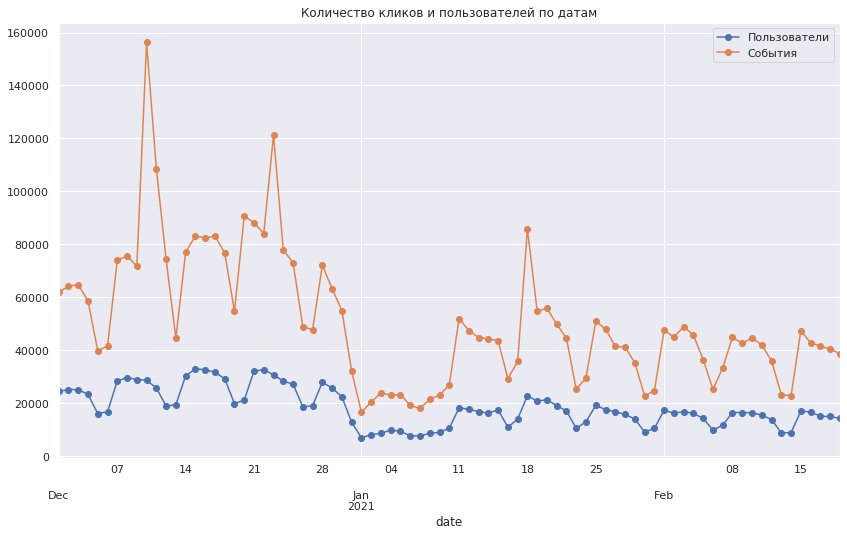

In [98]:
fav.groupby('date')[['users', 'hits']].sum().plot(title='Количество кликов и пользователей по датам', style='-o')
plt.legend(['Пользователи', 'События'])
plt.show()

Что можно отметить:
- по выходным количество обращений и соответственно пользователей падает. Немного другая картина в новогодние праздники - там на всём их протяжении показатели низкие;
- есть определённые пики по количеству нажатий в те дни, когда заметного роста количества новых пользователей мы не замечаем - стоит уточнить, вполне возможно, что в это время запустили какой-либо новый сервис, или же что-то вышло из строя, поэтому пользователи долго и безуспешно пытались добавить определённую категорию в "Избранное".

Попробуем понять, можно ли утверждать, что в декабре в среднем каждый день было больше посетителей ресурса, чем с января и до конца рассматриваемого периода.

<strong><font size=3>2.2. Гипотеза № 1 (о количестве пользователей в день):</font></strong><a name="2.2."></a><br/>
[<font size="2">(к содержанию)</font>](#to_content.)

<b>Сформулируем нулевую гипотезу:</b><br/>
Среднее число пользователей (в день), посетивших наш ресурс в декабре, приблизительно равно среднему числу пользователей, посетивших ресурс в остальной период (январь-февраль).

In [11]:
fav_users = fav.groupby('date')['users'].sum()

In [12]:
users_by_date_dec = fav_users[:31].values
users_by_date_rest = fav_users[31:].values

Посмотрим на размеры выборок:

In [13]:
len(users_by_date_dec)

31

In [14]:
len(users_by_date_rest)

50

Больше 30 элементов в каждой. Работаем:

In [15]:
ttest_ind(users_by_date_dec, users_by_date_rest)

Ttest_indResult(statistic=10.512156030050807, pvalue=1.1358793814264138e-16)

Можно с уверенностью сказать, что <b>в декабре показатель числа пользователей в день был выше, чем в остальное время.</b>

In [16]:
conf_interval_users_dec = sms.DescrStatsW(users_by_date_dec).tconfint_mean()
conf_interval_users_rest = sms.DescrStatsW(users_by_date_rest).tconfint_mean()

In [17]:
print(f"В декабре среднее значение посетителей в день составило {round(users_by_date_dec.mean())}\
 с доверительным интервалом ({round(conf_interval_users_dec[0])}, {round(conf_interval_users_dec[1])})")

В декабре среднее значение посетителей в день составило 25354 с доверительным интервалом (23312, 27397)


In [18]:
print(f"В январе-феврале среднее значение посетителей в день составило {round(users_by_date_rest.mean())}\
 с доверительным интервалом ({round(conf_interval_users_rest[0])}, {round(conf_interval_users_rest[1])})")

В январе-феврале среднее значение посетителей в день составило 14041 с доверительным интервалом (12878, 15204)


Посещаемость упала грандиозно. Интересно было бы узнать, с чем это может быть связано. Может быть, обновился интерфейс? Стоит это уточнить.

<hr style="border: 1px solid #000;"> 

<strong><font size=3>2.3. Проверим количество событий на пользователя по дням:</font></strong><a name="2.3."></a><br/>
[<font size="2">(к содержанию)</font>](#to_content.)

In [19]:
fav['mean_hits'] = (fav['hits'] / fav['users']).round(2)

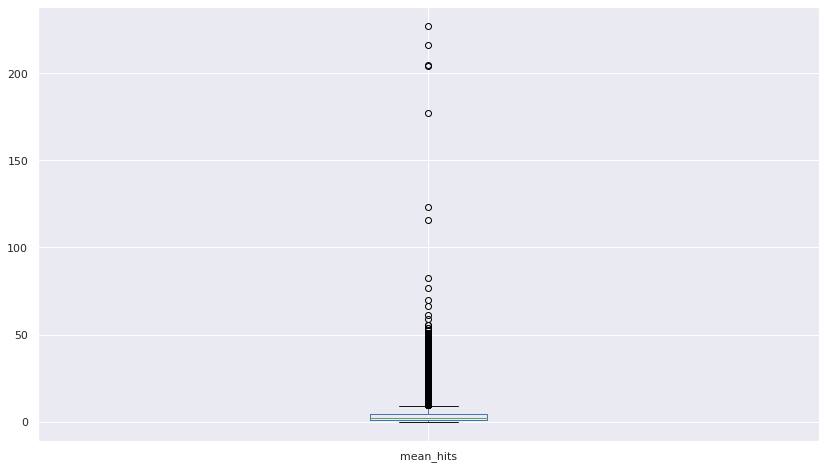

In [20]:
fav['mean_hits'].plot(kind='box')
plt.show()

Есть и по 50 кликов на юзера, есть и 200+, причем аж трижды. Взглянем на них:

In [21]:
fav.sort_values(by='mean_hits', ascending=False).head(10).reset_index(drop=True)

,date,hit_category,details,users,hits,week,mean_hits
0,2020-12-10,Просмотр блоков,Блок 1: Доступ к электронному дневнику,1,227,2020-12-10,227.00
1,2020-12-30,Просмотр блоков,Блок 1: Доступ к электронному дневнику,1,216,2020-12-24,216.00
2,2021-01-18,Просмотр блоков,Блок 1: Подача заявления и документов для назначения и предоставления единовременной компенсационной выплаты на возмещение расходов в связи с рождением (усыновлением) ребенка,1,205,2021-01-14,205.00
3,2020-12-21,Клик в разделе,Блок 1: Доступ к электронному дневнику,1,204,2020-12-17,204.00
4,2020-12-17,Просмотр блоков,Блок 1: Заявление на выпуск карты москвича для учащегося,1,177,2020-12-17,177.00
5,2020-12-21,Клик в разделе,"Блок 1: Запись на приём к врачу, отмена и перенос записи",1,123,2020-12-17,123.00
6,2020-12-26,Просмотр блоков,Блок 1: Заявление на выпуск карты москвича для учащегося,2,232,2020-12-24,116.00
7,2021-02-01,Просмотр блоков,Блок 1: null,3,247,2021-01-28,82.33
8,2021-01-22,Просмотр блоков,Блок 1: Запись на приём,3,230,2021-01-21,76.67
9,2021-01-14,Просмотр блоков,Блок 1: Предоставление информации жилищного учёта,3,209,2021-01-14,69.67


Получается, что у нас есть пользователи, которые в отдельно взятом дне просматривали блоки более 200 раз.

Конечно, стоит посмотреть историю использования сервиса в этот день по этим пользователям. Интересно посмотреть на разброс времени по действиям, добавили/удаляли ли они этот блок. В целом, воспользовались ли этой услугой.

Посмотрим на медианное количество событий на пользователя в разбивке по дням:

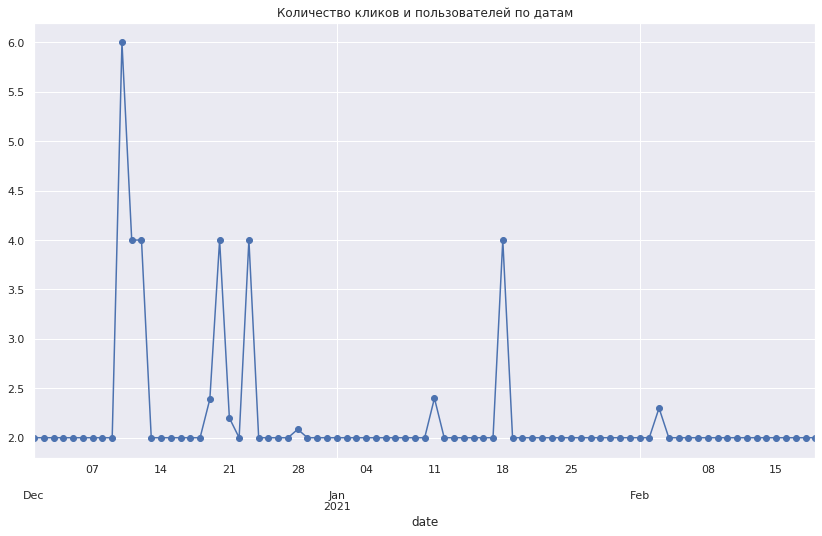

In [22]:
fav.groupby('date')['mean_hits'].median().plot(title='Количество кликов и пользователей по датам', style='-o')
plt.show()

В большей части случаев это 2 события на пользователя. Но есть и дни, когда это 6 дней на пользователя. Посмотрев чуть выше, можно заметить, что это как раз и есть те даты, когда отдельно взятые пользователи имели по 200+ событий. Посмотрим эти дни отдельно (возьмем значения, начиная с 95-го перцентиля и выше):

In [82]:
all_medians = fav.groupby('date')['mean_hits'].median()
perc_95 = np.percentile(fav.groupby('date')['mean_hits'].median(), 95)
max_dates = [date for date in all_medians.index if all_medians[date] >= perc_95]
max_dates

[Timestamp('2020-12-10 00:00:00'),
 Timestamp('2020-12-11 00:00:00'),
 Timestamp('2020-12-12 00:00:00'),
 Timestamp('2020-12-20 00:00:00'),
 Timestamp('2020-12-23 00:00:00'),
 Timestamp('2021-01-18 00:00:00')]

Сохраним эти даты. Впоследствии, когда разберемся со столбцом с блоками, вернёмся к нему и изучим - например, на предмет того, какой из блоков пользовался в эти дни наибольшой популярностью, и отличалось ли это как-то от картины любого другого, "среднего" дня. Плюс к этому, на графиках будем красным отмечать точки, которые соответствуют этим датам - вполне возможно, эти даты и явились "поворотными" для нашего сервиса - например, в этот день значительно выросло/упало значение какой-нибудь важной метрики (конверсия, количество пользователей и пр.).

<hr style="border: 1px solid #000;"> 

<strong><font size=3>2.4. Количество пользователей и событий по категориям</font></strong><a name="2.4."></a><br/>
[<font size="2">(к содержанию)</font>](#to_content.)

Посмотрим на уникальные значения столбца details:

In [24]:
fav['details'].unique()

array(['Блок 1: Проверка и пополнение баланса домашнего телефона МГТС, Блок 2: Запрос, изменение и отмена доступа к электронной медицинской карте',
       'Блок 1: Пополнение счёта карты ребёнка, Блок 2: Доступ к электронному дневнику, Блок 3: Запись в кружки, спортивные секции, дома творчества, Блок 4: Запись на приём к врачу, отмена и перенос записи',
       'Блок 1: Подача заявления и документов для назначения и предоставления единовременной компенсационной выплаты на возмещение расходов в связи с рождением (усыновлением) ребенка, Блок 2: Прием заявлений на запись (перевод) в образовательную организацию (дошкольные группы)',
       ...,
       'Блок 1: Предоставление информации жилищного учёта, Блок 2: Путёвки на отдых и оздоровление детей',
       'Блок 1: Запись на приём, Блок 2: Пополнение карты «Тройка», Блок 3: Предоставление информации жилищного учёта, Блок 4: Запись на приём к врачу, отмена и перенос записи',
       'Блок 1: Путёвки для отдыха и оздоровления детей, Блок 2: По

Если у нас несколько блоков в одной строке, значит, в каждый из них зашло столько пользователей, сколько указано в столбце <b>users</b>. Вытащим блоки в отдельный столбец, чтобы потом посчитать количество юзеров по ним:

In [25]:
fav['list_of_blocks'] = fav['details'].str.split(r',?\s?Блок\s\d:')
fav['list_of_blocks'] = fav['list_of_blocks'].apply(lambda list_: [element.strip() for element in list_ if len(element) > 0])

In [26]:
fav.head()

,date,hit_category,details,users,hits,week,mean_hits,list_of_blocks
0,2020-12-23,Просмотр блоков,"Блок 1: Проверка и пополнение баланса домашнего телефона МГТС, Блок 2: Запрос, изменение и отмена доступа к электронной медицинской карте",5,10,2020-12-17,2.00,"[Проверка и пополнение баланса домашнего телефона МГТС, Запрос, изменение и отмена доступа к электронной медицинской карте]"
1,2020-12-13,Просмотр блоков,"Блок 1: Пополнение счёта карты ребёнка, Блок 2: Доступ к электронному дневнику, Блок 3: Запись в кружки, спортивные секции, дома творчества, Блок 4: Запись на приём к врачу, отмена и перенос записи",25,91,2020-12-10,3.64,"[Пополнение счёта карты ребёнка, Доступ к электронному дневнику, Запись в кружки, спортивные секции, дома творчества, Запись на приём к врачу, отмена и перенос записи]"
2,2020-12-29,Просмотр блоков,"Блок 1: Подача заявления и документов для назначения и предоставления единовременной компенсационной выплаты на возмещение расходов в связи с рождением (усыновлением) ребенка, Блок 2: Прием заявлений на запись (перевод) в образовательную организацию (дошкольные группы)",122,226,2020-12-24,1.85,"[Подача заявления и документов для назначения и предоставления единовременной компенсационной выплаты на возмещение расходов в связи с рождением (усыновлением) ребенка, Прием заявлений на запись (перевод) в образовательную организацию (дошкольные группы)]"
3,2021-01-11,Просмотр блоков,"Блок 1: Запись на приём к врачу, отмена и перенос записи, Блок 2: Предоставление сведений Фондом капитального ремонта многоквартирных домов города Москвы, Блок 3: Предоставление информации технического учета в городе Москве, Блок 4: Предоставление информации жилищного учёта, Блок 5: Подписка на информирование о результатах лабораторных, инструментальных и иных видов диагностических исследований",5,10,2021-01-07,2.00,"[Запись на приём к врачу, отмена и перенос записи, Предоставление сведений Фондом капитального ремонта многоквартирных домов города Москвы, Предоставление информации технического учета в городе Москве, Предоставление информации жилищного учёта, Подписка на информирование о результатах лабораторных, инструментальных и иных видов диагностических исследований]"
4,2020-12-05,Просмотр блоков,"Блок 1: Поиск медучреждений, Блок 2: Путёвки на отдых и оздоровление детей, Блок 3: Запись в кружки, спортивные секции, дома творчества, Блок 4: Запись на приём, Блок 5: Запись на приём к врачу, отмена и перенос записи",5,56,2020-12-03,11.20,"[Поиск медучреждений, Путёвки на отдых и оздоровление детей, Запись в кружки, спортивные секции, дома творчества, Запись на приём, Запись на приём к врачу, отмена и перенос записи]"


Посчитаем количество юзеров, событий и среднее значение событий на юзера по каждому из блоков:

Для начала создадим массив блоков, которые у нас есть в разделе "Избранное" на сегодняшний день:
- Пополнение счёта карты ребёнка
- Путёвки на отдых и оздоровление детей
- Пополнение счёта парковочного пространства
- Оплата резидентного парковочного разрешения
- Поиск медучреждений
- Доступ к электронному дневнику
- Запись в кружки, спортивные секции, дома творчества
- Запись на приём
- Запись на приём к врачу, отмена и перенос записи
- Пополнение карты «Тройка»
- Предоставление информации жилищного учёта
- Предоставление информации о результатах государственной итоговой аттестации (ЕГЭ, ОГЭ, ГВЭ), итогового сочинения (изложения), итогового собеседования по русскому языку для 9 классов
- Предоставление информации о результатах муниципального этапа Всероссийской олимпиады школьников
- Предоставление информации технического учета в городе Москве
- Предоставление места для продажи товаров (оказания услуг, выполнения работ) на ярмарке выходного дня в городе Москве
- Предоставление сведений Фондом капитального ремонта многоквартирных домов города Москвы
- Прием заявлений на запись (перевод) в образовательную организацию (дошкольные группы)

Только по этим пунктам и будем смотреть статистику.

In [27]:
needed_blocks = ['Пополнение счёта карты ребёнка', 'Путёвки на отдых и оздоровление детей', 
                 'Пополнение счёта парковочного пространства', 'Оплата резидентного парковочного разрешения',
                 'Поиск медучреждений', 'Доступ к электронному дневнику', 
                 'Запись в кружки, спортивные секции, дома творчества', 'Запись на приём',
                 'Запись на приём к врачу, отмена и перенос записи', 'Пополнение карты «Тройка»',
                 'Предоставление информации жилищного учёта', 
                 """Предоставление информации о результатах государственной итоговой аттестации (ЕГЭ, ОГЭ, ГВЭ), 
                 итогового сочинения (изложения), итогового собеседования по русскому языку для 9 классов""",
                 'Предоставление информации о результатах муниципального этапа Всероссийской олимпиады школьников',
                 'Предоставление информации технического учета в городе Москве',
                 """Предоставление места для продажи товаров (оказания услуг, выполнения работ) на ярмарке 
                 выходного дня в городе Москве""",
                 'Предоставление сведений Фондом капитального ремонта многоквартирных домов города Москвы',
                 'Прием заявлений на запись (перевод) в образовательную организацию (дошкольные группы)']

Теперь очистим новый столбец <b>list_of_blocks</b> от элементов, не входящих в список выше:

In [28]:
fav_needed_blocks = fav.copy()
fav_needed_blocks['list_of_blocks'] = fav_needed_blocks['list_of_blocks'].apply(lambda list_: [element for element in list_ if
                                                                                               element in needed_blocks])
fav_needed_blocks = fav_needed_blocks.drop(['details'], axis=1)

In [29]:
fav_needed_blocks.head(2)

,date,hit_category,users,hits,week,mean_hits,list_of_blocks
0,2020-12-23,Просмотр блоков,5,10,2020-12-17,2.00,[]
1,2020-12-13,Просмотр блоков,25,91,2020-12-10,3.64,"[Пополнение счёта карты ребёнка, Доступ к электронному дневнику, Запись в кружки, спортивные секции, дома творчества, Запись на приём к врачу, отмена и перенос записи]"


Для удобства последующей работы сделаем так, чтобы одному блоку из столбца <b>list_of_blocks</b> соответствовала одна строка:

In [30]:
fav_needed_blocks = fav_needed_blocks.explode('list_of_blocks')
fav_needed_blocks = fav_needed_blocks.dropna()
fav_needed_blocks.head()

,date,hit_category,users,hits,week,mean_hits,list_of_blocks
1,2020-12-13,Просмотр блоков,25,91,2020-12-10,3.64,Пополнение счёта карты ребёнка
1,2020-12-13,Просмотр блоков,25,91,2020-12-10,3.64,Доступ к электронному дневнику
1,2020-12-13,Просмотр блоков,25,91,2020-12-10,3.64,"Запись в кружки, спортивные секции, дома творчества"
1,2020-12-13,Просмотр блоков,25,91,2020-12-10,3.64,"Запись на приём к врачу, отмена и перенос записи"
2,2020-12-29,Просмотр блоков,122,226,2020-12-24,1.85,Прием заявлений на запись (перевод) в образовательную организацию (дошкольные группы)


Стоит отметить, что теперь нам столбец <b>hits</b> не нужен, потому что теперь один блок - одна строка. Соответственно, за количество событий по каждому из блоков в каждый из дней будем принимать значение <b>mean_hits</b>.

In [31]:
fav_needed_blocks = fav_needed_blocks.drop(['hits'], axis=1)

Некоторые блоки имеют очень длинные названия. Для удобства мы их переименуем в более короткие, сохранив смысл:

In [32]:
to_rename = {'Пополнение счёта карты ребёнка': 'Карта ребёнка',
             'Путёвки на отдых и оздоровление детей': 'Путёвки для детей',
             'Пополнение счёта парковочного пространства': 'Парковка (город)',
             'Оплата резидентного парковочного разрешения': 'Парковка (прописка)',
             'Доступ к электронному дневнику': 'Эл. дневник',
             'Запись в кружки, спортивные секции, дома творчества': 'Кружки/секции',
             'Запись на приём к врачу, отмена и перенос записи': 'Запись к врачу',
             'Предоставление информации жилищного учёта': 'Жил. учёт',
              'Пополнение карты «Тройка»': 'Карта тройка',
             """Предоставление информации о результатах государственной итоговой аттестации (ЕГЭ, ОГЭ, ГВЭ), 
                 итогового сочинения (изложения), итогового собеседования по русскому языку для 9 классов""": 
             'Рез-ты экзаменов',
             'Предоставление информации о результатах муниципального этапа Всероссийской олимпиады школьников': 
             'Рез-ты олимпиад',
             'Предоставление информации технического учета в городе Москве': 'Тех. учёт',
             """Предоставление места для продажи товаров (оказания услуг, выполнения работ) на ярмарке 
                 выходного дня в городе Москве""": 'Ярмарка',
             'Предоставление сведений Фондом капитального ремонта многоквартирных домов города Москвы': 'Фонд капремонта',
             'Прием заявлений на запись (перевод) в образовательную организацию (дошкольные группы)': 'Смена сада'}

In [33]:
fav_needed_blocks['list_of_blocks_edited'] = (fav_needed_blocks['list_of_blocks'].map(to_rename)
                                              .fillna(fav_needed_blocks['list_of_blocks'])
                                             )

In [34]:
fav_needed_blocks.head(3)

,date,hit_category,users,week,mean_hits,list_of_blocks,list_of_blocks_edited
1,2020-12-13,Просмотр блоков,25,2020-12-10,3.64,Пополнение счёта карты ребёнка,Карта ребёнка
1,2020-12-13,Просмотр блоков,25,2020-12-10,3.64,Доступ к электронному дневнику,Эл. дневник
1,2020-12-13,Просмотр блоков,25,2020-12-10,3.64,"Запись в кружки, спортивные секции, дома творчества",Кружки/секции


In [35]:
fav_needed_blocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221756 entries, 1 to 129132
Data columns (total 7 columns):
date                     221756 non-null datetime64[ns]
hit_category             221756 non-null object
users                    221756 non-null uint8
week                     221756 non-null datetime64[ns]
mean_hits                221756 non-null float64
list_of_blocks           221756 non-null object
list_of_blocks_edited    221756 non-null object
dtypes: datetime64[ns](2), float64(1), object(3), uint8(1)
memory usage: 12.1+ MB


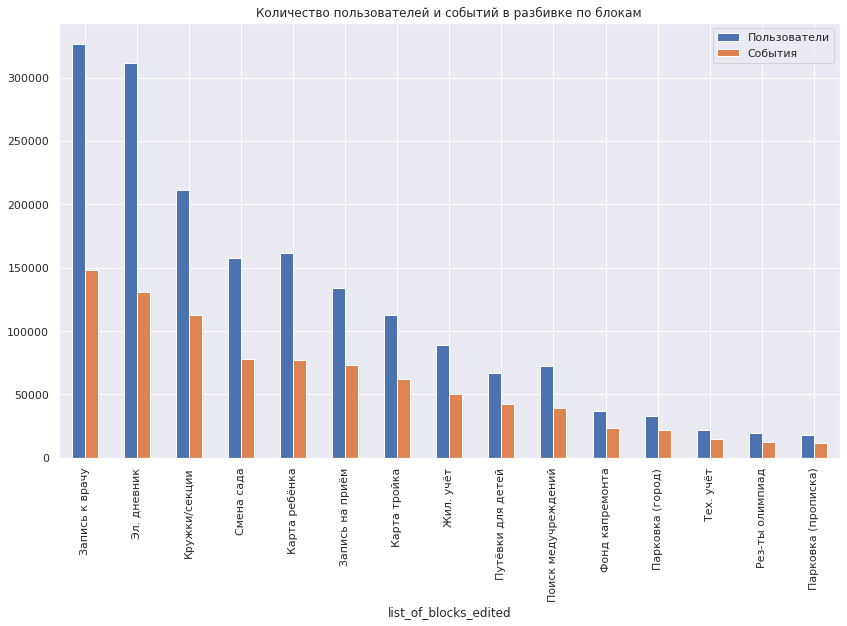

In [36]:
fav_needed_blocks_gr = (fav_needed_blocks.groupby('list_of_blocks_edited')[['users', 'mean_hits']].sum()
                             .sort_values(by='mean_hits', ascending=False)
                            )

fav_needed_blocks_gr.plot(kind='bar', title='Количество пользователей и событий в разбивке по блокам')
plt.legend(['Пользователи', 'События'])

plt.show()

Видим, что наибольшей популярностью пользуются блоки записи к врачу, электронного дневника и записи в кружки/секции.

На всякий случай убедимся, что ни один из этих блоков не является новым, и что все присутствовали в разделе "Избранное" на момент одной начальной даты:

In [37]:
fav_needed_blocks.groupby('list_of_blocks_edited')['date'].min().to_frame()

,date
list_of_blocks_edited,
Жил. учёт,2020-12-01
Запись к врачу,2020-12-01
Запись на приём,2020-12-01
Карта ребёнка,2020-12-01
Карта тройка,2020-12-01
Кружки/секции,2020-12-01
Парковка (город),2020-12-01
Парковка (прописка),2020-12-01
Поиск медучреждений,2020-12-01


Отдельно посмотрим на картину по дням, где отмечалось максимальное количество событий на пользователя (даты хранятся в <b>max_dates</b>):

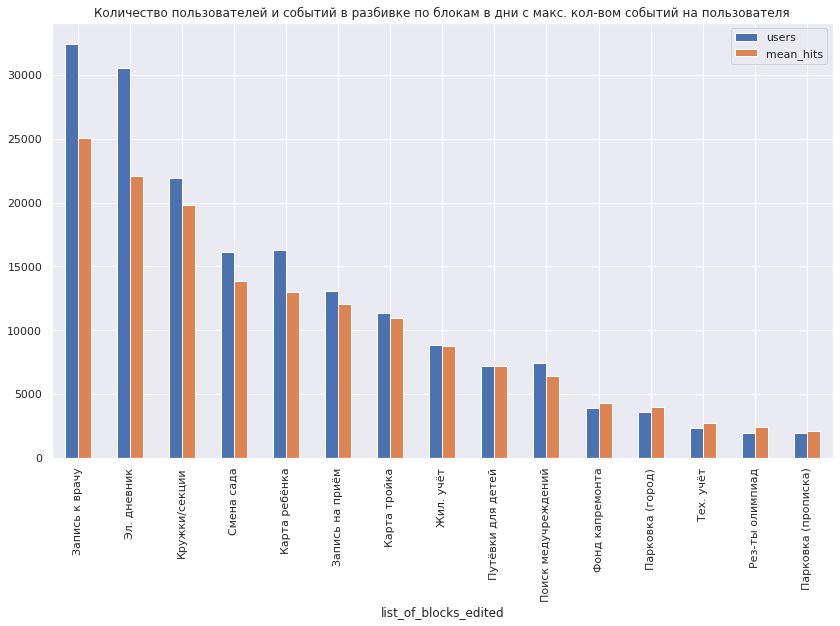

In [38]:
fav_needed_blocks_max_dates = fav_needed_blocks[fav_needed_blocks['date'].isin(max_dates)]

fav_needed_blocks_max_dates_gr = (fav_needed_blocks_max_dates.groupby('list_of_blocks_edited')[['users', 'mean_hits']].sum()
                             .sort_values(by='mean_hits', ascending=False)
                            )

title = """Количество пользователей и событий в разбивке по блокам в дни с макс. кол-вом событий на пользователя"""
fav_needed_blocks_max_dates_gr.plot(kind='bar', title=title)
plt.show()

Картина идентична той, что у нас получена выше. Другое дело, что количество событий, что объяснимо, относительно количества пользователей сильно выше.

<hr style="border: 1px solid #000;"> 

<strong><font size=3>2.5. Количество пользователей и событий по типу действия:</font></strong><a name="2.5."></a><br/>
[<font size="2">(к содержанию)</font>](#to_content.)

Взглянем на уникальные значения столбца <b>hit_category</b>:

In [39]:
fav['hit_category'].unique()

array(['Просмотр блоков', 'Клик в разделе', 'Добавление', 'Удаление',
       'Просмотр услуг'], dtype=object)

Посмотрим, какие действия пользователи совершают чаще всего:

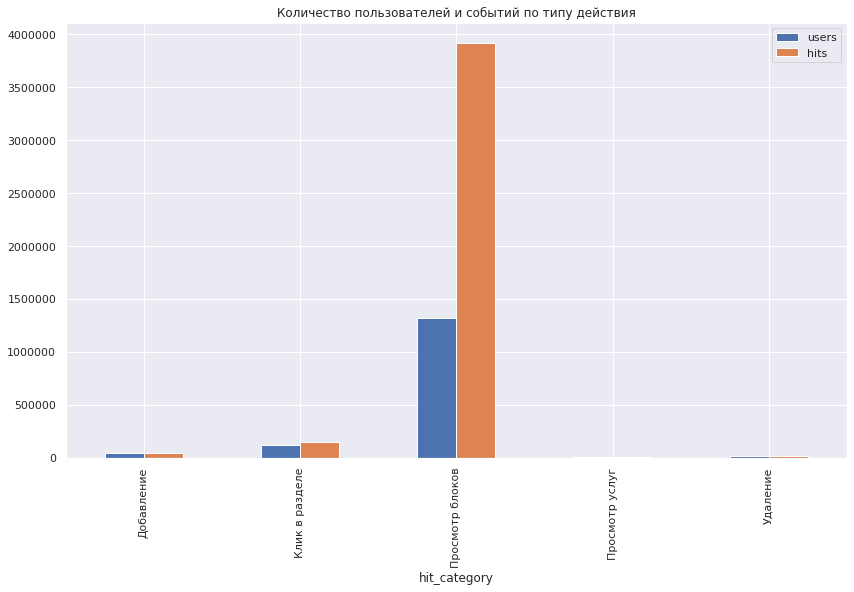

In [40]:
fav.groupby('hit_category')[['users', 'hits']].sum().plot(kind='bar', 
                                                          title='Количество пользователей и событий по типу действия')
plt.show()

Какое-то бешеное количество просмотров блоков, при этом конверсия - добавление к себе блока - вообще мизерная. Действий удаления ещё меньше.
<br/><br/>
Оценим конверсию:

In [41]:
len(fav.query('hit_category == "Добавление"'))/len(fav.query('hit_category not in ["Добавление", "Удаление"]'))

0.009566845468980827

Менее 1 процента? Ладно, посмотрим на дистанции:

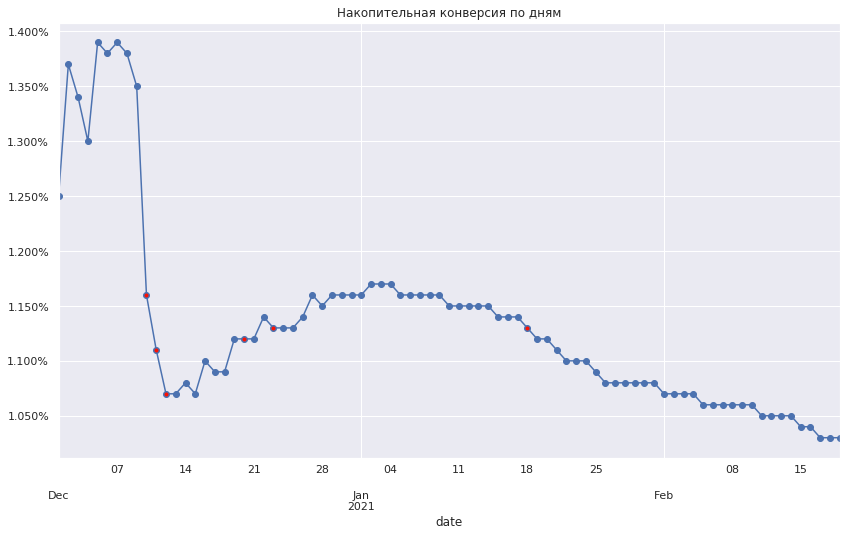

In [42]:
conversion_series = (fav.query('hit_category == "Добавление"').groupby('date')['users'].sum().cumsum() * 100 / \
fav.query('hit_category not in ["Добавление"]').groupby('date')['hits'].sum().cumsum()).round(2)

ax = conversion_series.plot(title='Накопительная конверсия по дням', style='-o')

conversion_series_max_dates = conversion_series[conversion_series.index.isin(max_dates)]

conversion_series_max_dates.plot(style='.', color='#ff1100')

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

Первые полторы недели конверсия была на уровне 1,3%, а потом резко упала до 1%.

Также стоит отметить, что те дни, когда мы наблюдали максимальное количество событий на пользователя, как раз и соответствуют дням, когда у нас наблюдается резкий спад уровня конверсии - 10-12 декабря. Что-то пошло не так, и пользователям стало непонятно, как пользоваться функциями блока "Избранное", поэтому они "тыкались", но не добавляли блоки к себе.

<hr style="border: 1px solid #000;"> 

<strong><font size=3>2.6. Гипотеза № 2 (о конверсии):</font></strong><a name="2.6."></a><br/>
[<font size="2">(к содержанию)</font>](#to_content.)

Сначала стоит обсудить, зачем нам вообще этот раздел.

По своей идее, сервис "Избранное" должен помогать нашим пользователям, не обращаясь к поиску услуг (который, как мы уже обсудили, не самый лучший), находить необходимую, обычно это будет часто используемая услуга, и работать с ней.

Это действительно очень сильно сокращает время взаимодействия с самим ресурсом, позволяя пользователям совершить все необходимые действия во много раз быстрее. В таком случае, в сухом виде мы должны получать то, что, как минимум, самые популярные у наших пользователей блоки должны попадать в "Избранное" если не после первого обращения к ним, то после второго.

<b>Первая гипотеза</b> будет звучать так: конверсия в декабре была такой же, как и конверсия в последующем периоде.<br/><br/>

За <b>alpha</b> возьмем значение 0.05. Используем тест Уэлча (выборки у нас будут содержать > 30 элементов каждая):

In [43]:
conversion_by_date = (fav.query('hit_category == "Добавление"').groupby('date')['users'].sum() / \
fav.query('hit_category not in ["Добавление", "Удаление"]').groupby('date')['hits'].sum())

In [44]:
conversion_by_date_dec = conversion_by_date[:31].values
conversion_by_date_rest = conversion_by_date[31:].values

In [45]:
ttest_ind(conversion_by_date_dec, conversion_by_date_rest)

Ttest_indResult(statistic=5.187081862107145, pvalue=1.60945096437601e-06)

Нулевая гипотеза отвергнута - <b>в декабре конверсия сервиса (совершение действия "Добавление") была статзначимо выше, чем в дальнейшем.</b>

Посмотрим на значения среднего и доверительные интервалы:

In [46]:
conf_interval_dec = sms.DescrStatsW(conversion_by_date_dec).tconfint_mean()
conf_interval_rest = sms.DescrStatsW(conversion_by_date_rest).tconfint_mean()

In [47]:
print(f"В декабре среднее значение конверсии составило {conversion_by_date_dec.mean():.2%}\
 с доверительным интервалом ({conf_interval_dec[0]:.2%}, {conf_interval_dec[1]:.2%})")

В декабре среднее значение конверсии составило 1.24% с доверительным интервалом (1.12%, 1.36%)


In [48]:
print(f"В период с 1 января по 19 февраля среднее значение конверсии составило {conversion_by_date_rest.mean():.2%}\
 с доверительным интервалом ({conf_interval_rest[0]:.2%}, {conf_interval_rest[1]:.2%})")

В период с 1 января по 19 февраля среднее значение конверсии составило 0.89% с доверительным интервалом (0.81%, 0.97%)


Очень хотелось бы посмотреть на данные до 1го декабря. Интересно, там была картина, которую мы имеем на первые 7 дней декабря, или мы просто наткнулись пик, который был создан определёнными условиями (например, рекламой по ТВ для москвичей об удобстве mos.ru). Но если окажется, что и до этого средняя конверсия была такая, как в первые 7 дней, то это будет явным поводом для дополнительного исследования, почему впоследствии конверсия так сильно упала (что в рамках того же декабря, так и после).

<hr style="border: 1px solid #000;"> 

<strong><font size=3>2.7. Как часто добавляют блоки:</font></strong><a name="2.7."></a><br/>
[<font size="2">(к содержанию)</font>](#to_content.)

Теперь посмотрим, как часто добавляют блоки к себе в "Избранное":

In [49]:
fav_needed_blocks['hit_category'].unique()

array(['Просмотр блоков', 'Добавление', 'Клик в разделе', 'Удаление'],
      dtype=object)

In [50]:
fav_add = fav_needed_blocks.query('hit_category == "Добавление"')

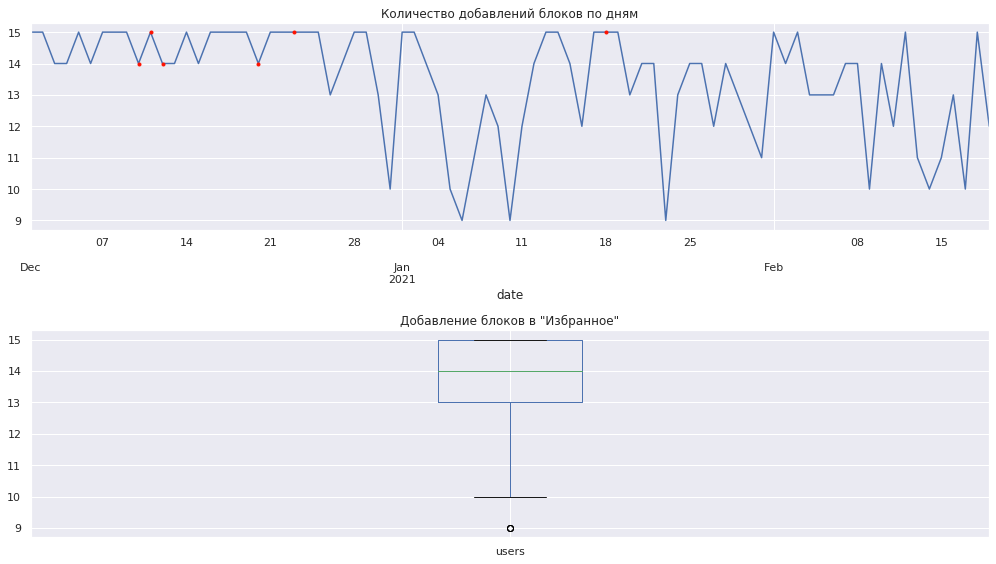

In [75]:
fig, axes=plt.subplots(2,1)

fav_add.groupby('date')['users'].count().plot(title='Количество добавлений блоков по дням', ax=axes[0])
#по max_dates
fav_add_max_dates = fav_add[fav_add['date'].isin(max_dates)]
fav_add_max_dates.groupby('date')['users'].count().plot(style='.', color='#ff1100', ax=axes[0])

fav_add.groupby('date')['users'].count().plot(kind='box', title='Добавление блоков в "Избранное"', ax=axes[1])

plt.tight_layout()
plt.show()

В среднем это 14 добавлений в день. Иногда падает и до 9. <br/><br/>

Что стоит отметить, так это то, что в декабре в день добавляли по 14-15 блоков, а начиная примерно с января, часто стали наблюдаться провалы до 9-10 добавлений. Если наложить на картину конверсий, то наблюдается прежняя картина - декабрь более "продуктивный", чем остальной период.

К слову, в дни, когда мы наблюдали провалы по конверсии и, соответственно, рост количества событий в отсутствии роста количества пользователей, статистика такая же, как и в остальные дни. Другими словами, событий было больше, а вот добавлений в "Избранное" осталось столько же.

<hr style="border: 1px solid #000;"> 

<strong><font size=3>2.8. Гипотеза № 3 (о среднем количестве добавляемых объявлений в день):</font></strong><a name="2.8."></a><br/>
[<font size="2">(к содержанию)</font>](#to_content.)

<b>Вторая гипотеза</b> будет звучать так:<br/>в декабре в блок "Избранное" каждый день в среднем добавляли столько же блоков, сколько и последующем периоде.<br/><br/>

За <b>alpha</b> возьмем значение 0.05.

In [52]:
fav_add_gr = fav_add.groupby('date')['users'].count()

In [53]:
adding_by_date_dec = fav_add_gr[:31].values
addin_by_date_rest = fav_add_gr[31:].values

In [54]:
ttest_ind(adding_by_date_dec, addin_by_date_rest)

Ttest_indResult(statistic=4.24073446617499, pvalue=6.0016003364512854e-05)

Такая же ситуация, как и по конверсии - <b>в декабре в "Избранное" добавляли больше, чем в остальной период.</b>

Посмотрим на средние значения и доверительные интервалы:

In [55]:
adding_interval_dec = sms.DescrStatsW(adding_by_date_dec).tconfint_mean()
adding_interval_rest = sms.DescrStatsW(addin_by_date_rest).tconfint_mean()

In [56]:
print(f"В декабре среднее значение блоков, добавленных в 'Избранное', составило {round(adding_by_date_dec.mean(),2)}\
 с доверительным интервалом ({round(adding_interval_dec[0])}, {round(adding_interval_dec[1])})")

В декабре среднее значение блоков, добавленных в 'Избранное', составило 14.42 с доверительным интервалом (14, 15)


In [57]:
print(f"В период с 1 января по 19 февраля среднее значение блоков, добавленных в 'Избранное', составило \
{round(addin_by_date_rest.mean(),2)}\
 с доверительным интервалом ({round(adding_interval_rest[0])}, {round(adding_interval_rest[1])})")

В период с 1 января по 19 февраля среднее значение блоков, добавленных в 'Избранное', составило 12.9 с доверительным интервалом (12, 13)


<hr style="border: 1px solid #000;"> 

<strong><font size=3>2.9. Какие блоки добавляют/удаляют:</font></strong><a name="2.9."></a><br/>
[<font size="2">(к содержанию)</font>](#to_content.)

Посмотрим, наконец, какие блоки пользовались наибольшей популярностью:

In [58]:
fav_delete = fav_needed_blocks.query('hit_category == "Удаление"')

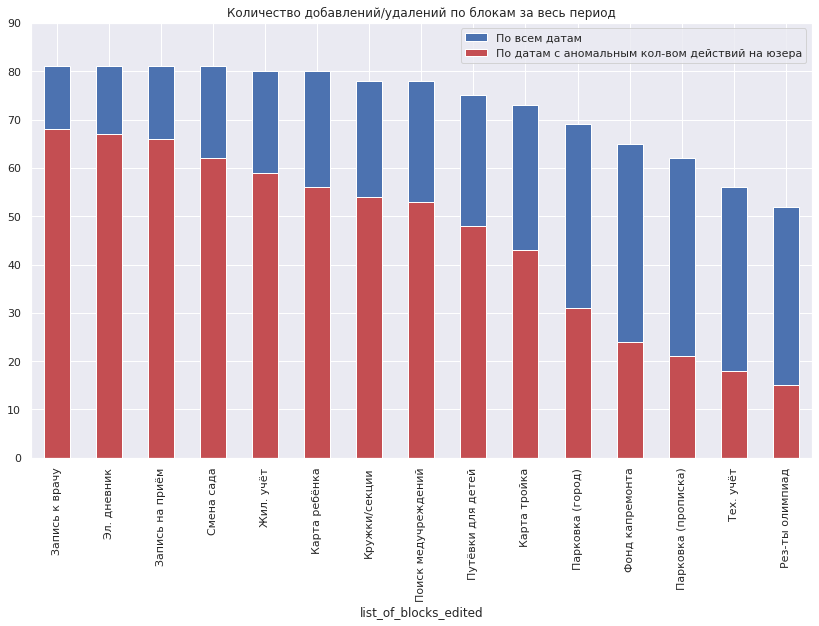

In [95]:
(fav_add.groupby('list_of_blocks_edited')['users'].count()
 .sort_values(ascending=False)
 .plot(kind='bar', title='Количество добавлений/удалений по блокам за весь период')
)
fav_delete.groupby('list_of_blocks_edited')['users'].count().sort_values(ascending=False).plot(kind='bar', color='r')
plt.ylim(0,90)
plt.legend(['По всем датам', 'По датам с аномальным кол-вом действий на юзера'])
plt.show()

Есть подозрение, что это вообще одни и те же пользователи - кто "научился" пользоваться сервисом "Избранное", и он им понравился - а то слишком ровная картина получается. Это стоит проверить, заимев полные данные.<br/><br/>

Просто заметить, что по самым популярным услугам процент удаления довольно высокий - около 80%. При этом по менее популярным услугам он не превышает и 50%.

Не вижу смысла делить блоки на группы и сравнить отношение удалений к добавлениям. Добавляют/удаляют блоки всего 1 раз в день (а то и реже). Это крайне малая степень взаимодействия с сервисом.

Так как тут на один день выборка из 80 добавлений по блоку, то, конечно, посмотрим на картину по датам с провалами в конверсии, но выборка будет слишком мала.

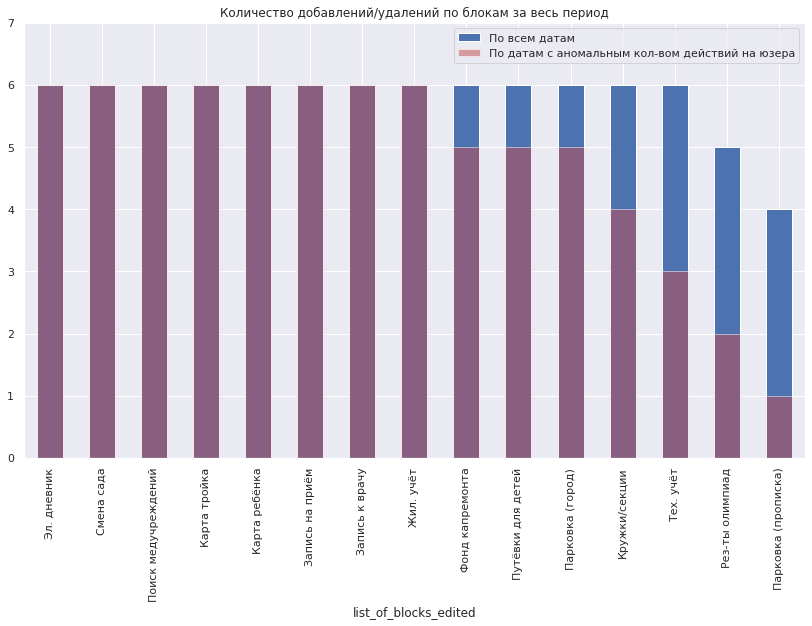

In [96]:
fav_delete_max_dates = fav_delete[fav_delete['date'].isin(max_dates)]

(fav_add_max_dates.groupby('list_of_blocks_edited')['users'].count()
 .sort_values(ascending=False)
 .plot(kind='bar', title='Количество добавлений/удалений по блокам за весь период')
)
fav_delete_max_dates.groupby('list_of_blocks_edited')['users'].count().sort_values(ascending=False).plot(kind='bar', 
                                                                                                         color='r',
                                                                                                         alpha=0.5)

plt.ylim(0,7)
plt.legend(['По всем датам', 'По датам с аномальным кол-вом действий на юзера'])
plt.show()

Сколько добавляют, столько и удаляют. Но выборка крайне мала.

<hr style="border: 1px solid #000;"> 

<strong><font size=3>2.10. Действия внутри блоков (клики):</font></strong><a name="2.10."></a><br/>
[<font size="2">(к содержанию)</font>](#to_content.)

In [60]:
fav_clicks = fav_needed_blocks.query('hit_category == "Клик в разделе"')

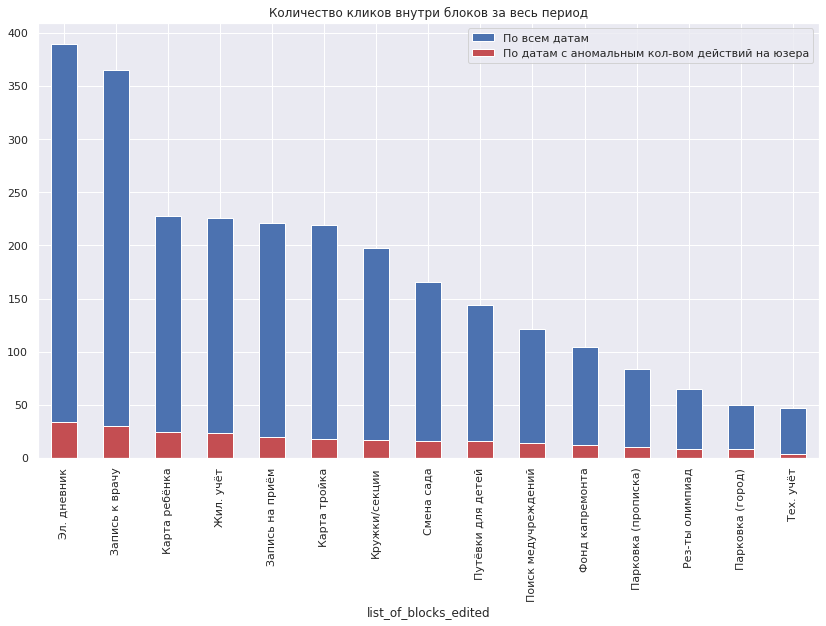

In [97]:
(fav_clicks.groupby('list_of_blocks_edited')['users'].count().
 sort_values(ascending=False)
 .plot(kind='bar', title='Количество кликов внутри блоков за весь период')
)

(fav_clicks[fav_clicks['date'].isin(max_dates)].groupby('list_of_blocks_edited')['users'].count().
 sort_values(ascending=False)
 .plot(kind='bar', color='r')
)

plt.legend(['По всем датам', 'По датам с аномальным кол-вом действий на юзера'])

plt.show()

Картина аналогична тем, которые получали выше, - в лидерах те же блоки.

<hr style="border: 1px solid #000;"> 

<strong><font size=5>3. Итоги</font></strong><a name="3."></a><br/>
[<font size="2">(к содержанию)</font>](#to_content.)

У нас в распоряжении данные за период с 2020-12-01 по 2021-02-19. Что мы отметили:

1. В определённые дни есть пики по количеству событий на пользователя. Это должно быть с чем-то связано - будь то добавление новой услуги, например, или же в новостях Москвы сказали, что до какого-то момента необходимо успеть оформить какую-либо услугу.

<img src="https://i.ibb.co/mSXq8m8/image.png" alt="image" border="0"><br />

2. Поделили рассматриваемый период на 2 диапазона: декабрь и оставшийся период (январь-19 февраля). Почему именно так? С 1-го января визуально график как по количеству пользователей, так и по количеству событий стал проходить заметно ниже, чем в декабре.

И наши предположения подтвердились - <b>Гипотеза № 1</b> - в декабре количество пользователей статзначимо было больше, чем на оставшемся отрезке времени. То есть после праздников у нас некоторое количество пользователей ушло. Причиной этому может быть то, что в конце года люди стараются успеть оформить некоторые услуги - кто-то решить вопрос со здоровьем, кому-то необходимо решить вопрос с жил. учётом. Тем не менее, в нашем перечне нет списков тех услуг, которые явно бы брали на себя ответственность по снижению количества пользователей. Например, если б это была услуга оформления налогового вычета, то было бы вполне объяснимо, почему у нас была такая активность в декабре и почему она так снизилась, начиная с 1-го января. Но все наши услуги выглядят такими, к которым мы можем обращаться регулярно (еженедельно/ежемесячно) вне зависимости от того, оканчивается календарный год или нет. Поэтому стоит посмотреть юзер-стори по пользователям, которые были у нас в декабре, и сравнить их действия с теми пользователями, которые посещали нас уже после 1го января. Вполне возможно, мы сможем там найти какие-либо паттерны, которые помогут нам составить разностный портрет между двумя этими пользователями.

3. В дни пиков по событиям как раз и присутствует аномальное среднее количество событий на 1 пользователя. Присутствуют значения и по 200 единиц (событий). Здесь тоже стоит выяснить, как так произошло и почему. Версия о смене интерфейса сервиса "Избранное" (или схемы взаимодействия с ним) выглядит довольно правдоподобно.

4. График конверсии как раз пошёл на спад в те дни, когда у нас наблюдалось аномальное количество событий на пользователя. То есть событий на одного юзера стало больше, а вот конверсия (добавление блоков к себе в "Избранное") не увеличилось. Что подсказывает нам, что что-то стало работать не так.<br/><br/>

Здесь наша <b>Гипотеза № 2</b> о том, что конверсия в декабре была такой же, как в остальной период времени, была отвергнута. Другими словами, конверсия в декабре была выше, чем в период с января по 19 февраля. То есть к нам пришли пользователи, которые стали реже пользоваться сервисом "Избранное" по его прямому назначению - добавлению блоков услуг к себе.

<img src="https://i.ibb.co/PMtnsJb/image.png" alt="image" border="0"><br />

Дополнительным подтверждением этого служит ещё и график медианного количество добавляемых блоков в день - начиная с января, можно заметить, что количество "провалов" по части того, сколько раз добавляют блоки к себе в "Избранное", сильно увеличилось.
Об этом же нам сказали и результаты <b>Гипотезы № 3</b> - в декабре блоки добавляли чаще, чем в остальной период времени.

<img src="https://i.ibb.co/gRLcBg9/image.png" alt="image" border="0">

5. Дополнительно ещё получили данные о том, блоки каких услуг добавляют к себе чаще (или удаляют):

<img src="https://i.ibb.co/T1GFp4y/image.png" alt="image" border="0">

80 добавлений к себе в "Избранное" на 1 блок за <b>весь</b> рассматриваемый период - это катастрофически мало. Учитывая то, что в день мы замечаем по 15000-25000 пользователей.

<hr style="border: 1px solid #000;"> 

<strong><font size=5>4. Каких данных не хватает/что стоит сделать</font></strong><a name="4."></a><br/>
[<font size="2">(к содержанию)</font>](#to_content.)

- отлично было бы заиметь не агрегированные данные, а детальные - <b>id пользователя - временная отметка - где он делал - что он делал</b>. Это позволит нам отдельно изучить поведение тех пользователей, кто по 200 раз просматривал один и тот же блок, но не добавлял его к себе. Вполне возможно, он не разобрался с тем, что там делать. И стоит отдельно посмотреть, 200 событий - это за 1 сессию, или же пользователь утром, днём и вечером в 3 захода пробовал совершить необходимое ему действие, но так и не сделал этого;
- отдельно хотелось бы получить информацию о том, <b>какие услуги пользователи всё же заказывают</b>. Не просматривают, не щёлкают внутри, а именно заказывают. Скорее всего, картина будет похожа на график, который описывает у нас количество взаимодействий между пользователями и блоками, но всё же эта информация позволила бы более точно определить по блокам лидеров по количеству успешных взаимодействий и сравнить эти данные с тем, как часто эти блоки добавляют к себе в "Избранное";
- хотелось бы с начальном страницы кабинета получить данные по пользователям о том, <b>как часто они вообще заходят в "Избранное"</b>. Здесь у нас данные по тем пользователям, кто хоть как-то взаимодействовал с этим сервисом, но интересно было бы посмотреть и на тех, кто этот сервис игнорирует полностью. И выяснить, почему так происходит. На  мой взгляд, "блок" с этим сервисом хоть и находится наверху, но он не бросатся в глаза. Более того, сходу не понять, какие преимущества он даёт. Стоит провести <b>A/B-тест</b>, где изменениями будут, например, автоматическое определение самой "популярной" услуги у пользователя и добавлением в раздел "Избранное" кнопки "Добавить *услуга* в Избранное, чтобы она всегда была под рукой". И посмотреть на то, как пользователь будет взаимодействовать с сервисом в этом случае - в случае, когда у него не будет необходимости листать весь список имеющихся услуг, а достаточно будет сделать лишь 1 нажатие и добавить нужный ему блок к себе в "Избранное";
- с теми, кто насмотрелся по 200 раз на один и тот же блок за день, стоит по телефону обсудить вопрос о том, что они находят в сервисе удобным или, наоборот, неудобным. Это позволит нам понять, что конкретно им помешало добавить блок в "Избранное" или же из-за чего это желание и не возникало;
- получить данные за весь прошлый год было бы полезно. Так мы бы смогли сравнить январь-февраль с январем-февралем прошлого года, что позволило бы исключить сезонность. Более того, мы бы разобрались, был ли декабрь определённым пиком или же и ранее пользователей, которые взаимодействуют с сервисом "Избранное", в среднем было больше, чем ранее.